### Pipeline Multi-Classification

L'objectif de ce notebook est d'expérimenter avec divers modèles pour résoudre une tâche de classification multiclasse. 
Plus précisément, nous cherchons à prédire à partir des données lors d'un demarragge d'un job, quel type de criticité est susceptible de survenenir à savoir; 
- Info
- Warning
- Error
- Aucun

Ce model sera le premier d'une paire de model ayant comme objectif de predire un type d'erreur précis. 
Si ce model predit une erreur, le deuxième model predira le type d'erreur que nous allons rencontré.

In [1]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV,learning_curve

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, roc_curve, auc , roc_auc_score,make_scorer, precision_score, f1_score


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from lightgbm import LGBMClassifier
# ---------------------------------------------------
# Windows users need to install Visual C++ Redistributable

# XGBoost requires DLLs from Visual C++ Redistributable in order to function, so make sure to install it. 
# Exception: If you have Visual Studio installed, you already have access to necessary libraries and thus don’t need to install Visual C++ Redistributable.
from xgboost import XGBClassifier
# ---------------------------------------------------

import mlflow
import mlflow.sklearn
from joblib import dump, load
import json

In [2]:
# nom de fichier et chemin relatif
filename = 'merged_printers_data_criticality.csv'
path = './data/'
# création d'un dataframe à partir du csv de données
df = pd.read_csv(path+filename, index_col=0)
df.head(2)

,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,drops,...,y_imageLayout,power_irDryers,power_uvDryers,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,criticality_events,machineID
duration,,,,,,,,,,,,,,,,,,,,,
171.889,700,520,740,2,False,1,1,0.059481,10,1,...,0,45,100,1500,1500,1500,16,16,INFO,14
171.889,700,520,740,2,False,1,1,0.059481,10,1,...,0,45,100,1500,1500,1500,16,16,INFO,14


In [3]:
df.shape

(90989, 24)

In [4]:
df.columns

Index(['speed', 'paperHeight_job', 'paperWidth_job', 'total_copies_requested',
       'ifoil', 'scanner_mode', 'bars_job', 'varnishConsumptionVarnish_3d_job',
       'LED', 'drops', 'speed_ifoil', 'heater1Enabled_ifoil',
       'heater1Temperature_ifoil', 'x_imageLayout', 'y_imageLayout',
       'power_irDryers', 'power_uvDryers',
       'redScore_gridMode_remoteScannerRegistration',
       'redScore_cropmarksMode_remoteScannerRegistration',
       'redScore_fullScannerMode_remoteScannerRegistration',
       'blueScore_fullScannerMode_remoteScannerRegistration',
       'greenScore_fullScannerMode_remoteScannerRegistration',
       'criticality_events', 'machineID'],
      dtype='object')

In [5]:
df['criticality_events'].unique()

array(['INFO', 'ERROR', 'WARNING', 'NO_EVENT'], dtype=object)

In [6]:
df['criticality_events'].nunique()

4

In [7]:
df['criticality_events'].value_counts() 

INFO        26231
ERROR       26231
NO_EVENT    25557
WARNING     12970
Name: criticality_events, dtype: int64

----

In [8]:
df.drop('machineID',axis=1,inplace=True)

# Sous-échantillonnage / Sur-échantillonnage

In [9]:
balanced_method = "over-sampling"
# choisir entre "under-sampling", "over-sampling" and "no-balancing"


if balanced_method == "under-sampling":
    # Obtenir le nombre minimum d'instances parmi les classes
    min_class_count = df['criticality_events'].value_counts()['ERROR']  # Nombre d'instances dans la classe minoritaire ERROR

    # Pour chaque classe non-ERROR, sous-échantillonner pour obtenir min_class_count instances
    balanced_df = pd.DataFrame()
    for class_name in ['INFO', 'NO_EVENT', 'WARNING']:
        class_subset = df[df['criticality_events'] == class_name]
        sampled_subset = class_subset.sample(min(min_class_count, len(class_subset)), random_state=42) 
        balanced_df = pd.concat([balanced_df, sampled_subset], axis=0)
    

   # Ajouter les instances ERROR sans changement
    df_error = df[df['criticality_events'] == 'ERROR']
    balanced_df = pd.concat([balanced_df, df_error], axis=0)

    # Mélanger le DataFrame final
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Remplacer le DataFrame original par le DataFrame équilibré
    df = balanced_df

    # Créer une nouvelle colonne 'binary_class' avec des valeurs booléennes
    df['error'] = df['criticality_events'].apply(lambda x: True if x == 'ERROR' else False)

    # Séparez les données en deux DataFrames, un pour chaque classe
    df_error = df[df['error'] == True]
    df_non_error = df[df['error'] == False]

    # Pour équilibrer les classes, divisez la classe 'NON_ERROR' en trois et prenez une partie
    # La méthode sample de pandas est utilisée pour générer un échantillon aléatoire d'éléments à partir de notre ensemble de données. 
    df_non_error = df_non_error.sample(len(df_non_error)//3, random_state=42)

    # Fusionner les deux DataFrames en un seul
    df = pd.concat([df_error, df_non_error], axis=0)

    print(df['criticality_events'].value_counts())

    info_count = df['criticality_events'].value_counts()['INFO']
    error_count = df['criticality_events'].value_counts()['ERROR']
    no_event_count = df['criticality_events'].value_counts()['NO_EVENT']
    warning_count = df['criticality_events'].value_counts()['WARNING']

    df.drop(columns='criticality_events', inplace=True)
    
    # Séparation des données avec train_test_split
    X = df.drop('error', axis=1)
    y = df['error']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


    # fusion des test set pour l'input json
    example_input = pd.concat([X_test, y_test], axis=1)

    # 1. Sélectionner les dernières lignes de `example_input` pour un exemple d'entrée MLFLOW
    last_rows_example = example_input.iloc[-5:]

    # Créer un objet JSON en utilisant les lignes et noms de colonnes originaux
    example_input_json = last_rows_example.to_dict('records')

    # Recombiner les deux DataFrames
    df_balanced = pd.concat([df_error, df_non_error], axis=0)


    # On reset l'index sinon la duration est l'index
    df.reset_index(inplace=True)

    # Mélanger les données
    df = df_balanced.sample(frac=1, random_state=42)

    true_count = y_train[y_train == True].shape[0]
    false_count = y_train[y_train == False].shape[0]


    sampling_info = (
    "Sous-échantillonnage réalisé pour équilibrer les classes. "
    "Distribution initiale : INFO: {}, ERROR: {}, NO_EVENT: {}, WARNING: {}. "
    "Chaque classe a été réduite à {} échantillons, correspondant au nombre dans la classe 'WARNING'. "
    "Les classes 'INFO', 'NO_EVENT' et 'WARNING' ont été fusionnées en une classe 'FALSE' (pas d'erreur), "
    "et la classe 'ERROR' a été renommée 'TRUE' (erreur), résultant en deux nouvelles classes plus équilibrées : "
    "'TRUE': {} et 'FALSE': {}.").format(
        info_count, error_count, no_event_count, warning_count,
        warning_count, true_count, false_count)

    do_smote = False


elif balanced_method == "over-sampling":
    # Créer une nouvelle colonne 'binary_class' avec des valeurs booléennes

    df['error'] = df['criticality_events'].apply(lambda x: True if x == 'ERROR' else False)

    print(df['criticality_events'].value_counts())

    info_count = df['criticality_events'].value_counts()['INFO']
    error_count = df['criticality_events'].value_counts()['ERROR']
    no_event_count = df['criticality_events'].value_counts()['NO_EVENT']
    warning_count = df['criticality_events'].value_counts()['WARNING']

    df.drop(columns='criticality_events', inplace=True)

    # On reset l'index sinon la duration est l'index
    df.reset_index(inplace=True)

    df = df.sample(frac=1, random_state=42)
   
    # Séparation des données avec train_test_split
    X = df.drop('error', axis=1)
    y = df['error']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    # fusion des test set pour l'input json
    example_input = pd.concat([X_test, y_test], axis=1)

    # Sélectionner les dernières lignes de `example_input` pour un exemple d'entrée MLFLOW
    last_rows_example = example_input.iloc[-5:]

    # Créer un objet JSON en utilisant les lignes et noms de colonnes originaux
    example_input_json = last_rows_example.to_dict('records')

    true_count = y_train[y_train == True].shape[0]
    false_count = y_train[y_train == False].shape[0]

    
    do_smote = True

else:
    balanced_method = "no-balancing"
     # Créer une nouvelle colonne 'binary_class' avec des valeurs booléennes
    df['error'] = df['criticality_events'].apply(lambda x: True if x == 'ERROR' else False)
   
    print(df['criticality_events'].value_counts())

    info_count = df['criticality_events'].value_counts()['INFO']
    error_count = df['criticality_events'].value_counts()['ERROR']
    no_event_count = df['criticality_events'].value_counts()['NO_EVENT']
    warning_count = df['criticality_events'].value_counts()['WARNING']

    df.drop(columns='criticality_events', inplace=True)

    # On reset l'index sinon la duration est l'index
    df.reset_index(inplace=True)

    # Mélanger les données
    df = df.sample(frac=1, random_state=42)

    # Séparation des données avec train_test_split
    X = df.drop('error', axis=1)
    y = df['error']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


    # fusion des test set pour l'input json
    example_input = pd.concat([X_test, y_test], axis=1)

    # Sélectionne les dernières lignes de `example_input` pour un exemple d'entrée MLFLOW
    last_rows_example = example_input.iloc[-5:]

    # Créer un objet JSON en utilisant les lignes et noms de colonnes originaux
    example_input_json = last_rows_example.to_dict('records')

    true_count = y_train[y_train == True].shape[0]
    false_count = y_train[y_train == False].shape[0]

    sampling_info = ("Aucun équilibrage des classes n'a été effectué. Les classes sont laissées dans leur état d'origine déséquilibré. "
    "Distribution initiale : INFO: {}, ERROR: {}, NO_EVENT: {}, WARNING: {}. "
    "Les classes 'INFO', 'NO_EVENT' et 'WARNING' ont été fusionnées en une classe 'FALSE' (pas d'erreur), "
    "et la classe 'ERROR' a été renommée 'TRUE' (erreur), résultant en deux nouvelles classes déséquilibrées : "
    "'TRUE': {} et 'FALSE': {}.").format(
        info_count, error_count, no_event_count, warning_count,
        warning_count, true_count, false_count)


    do_smote = False


total_size = len(X)  # Taille totale avant SMOTE
test_size_percentage = len(X_test) / total_size

print('------------------')
print(df['error'].value_counts())
print(y_test.value_counts())
print('------------------')


INFO        26231
ERROR       26231
NO_EVENT    25557
WARNING     12970
Name: criticality_events, dtype: int64
------------------
False    64758
True     26231
Name: error, dtype: int64
False    12974
True      5224
Name: error, dtype: int64
------------------


In [10]:
df.head(5)

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,x_imageLayout,y_imageLayout,power_irDryers,power_uvDryers,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,error
708,168.661,313,520,740,75,False,1,2,2.485330,30,...,70,0,45,100,1500,1500,1500,26,26,False
54046,132.785,251,483,330,17,True,2,1,3.310549,50,...,1485,14,45,70,4000,4000,4000,20,20,False
3955,7.753,313,520,740,125,False,1,2,0.000000,30,...,69,-12,45,100,3135,3135,3135,33,32,True
30674,567.569,317,520,740,300,False,1,2,51.152751,10,...,70,0,45,100,2561,2561,2561,16,16,True
54549,166.600,251,483,330,66,True,2,1,0.310201,50,...,1485,14,45,70,4000,4000,4000,20,20,True


In [11]:
try:
    print(df_non_error['error'].value_counts())
except:
    pass

In [12]:
df.head(2)

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,x_imageLayout,y_imageLayout,power_irDryers,power_uvDryers,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,error
708,168.661,313,520,740,75,False,1,2,2.485330,30,...,70,0,45,100,1500,1500,1500,26,26,False
54046,132.785,251,483,330,17,True,2,1,3.310549,50,...,1485,14,45,70,4000,4000,4000,20,20,False


In [13]:
df.dtypes

duration                                                float64
speed                                                     int64
paperHeight_job                                           int64
paperWidth_job                                            int64
total_copies_requested                                    int64
ifoil                                                      bool
scanner_mode                                              int64
bars_job                                                  int64
varnishConsumptionVarnish_3d_job                        float64
LED                                                       int64
drops                                                     int64
speed_ifoil                                             float64
heater1Enabled_ifoil                                       bool
heater1Temperature_ifoil                                  int64
x_imageLayout                                             int64
y_imageLayout                           

In [14]:
df.head()

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,x_imageLayout,y_imageLayout,power_irDryers,power_uvDryers,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,error
708,168.661,313,520,740,75,False,1,2,2.485330,30,...,70,0,45,100,1500,1500,1500,26,26,False
54046,132.785,251,483,330,17,True,2,1,3.310549,50,...,1485,14,45,70,4000,4000,4000,20,20,False
3955,7.753,313,520,740,125,False,1,2,0.000000,30,...,69,-12,45,100,3135,3135,3135,33,32,True
30674,567.569,317,520,740,300,False,1,2,51.152751,10,...,70,0,45,100,2561,2561,2561,16,16,True
54549,166.600,251,483,330,66,True,2,1,0.310201,50,...,1485,14,45,70,4000,4000,4000,20,20,True


In [15]:
# # Encodage de la colonne 'y' avec LabelEncoder
# encoder = LabelEncoder()
# df['criticality_events'] = encoder.fit_transform(df['criticality_events'])

In [16]:
example_input.head()

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,x_imageLayout,y_imageLayout,power_irDryers,power_uvDryers,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,error
27719,4953.432,500,1040,740,1100,False,1,2,824.446450,10,...,70,0,45,100,2561,2561,2561,16,16,False
32810,807.012,243,920,650,1000,False,1,2,2.147648,10,...,708,0,45,100,2561,2561,2561,10,10,False
2913,6070.833,404,520,740,1200,False,1,2,811.998815,10,...,70,0,45,100,3135,3135,3135,33,32,False
76268,203.549,313,483,330,30,True,3,2,1.650535,40,...,1501,-22,20,60,1500,1500,1500,24,25,False
49087,165.738,209,483,330,33,True,3,1,1.089892,50,...,1492,11,45,70,1500,1500,1500,20,20,False


In [17]:
# True pour utiliser StandardScaler, False pour utiliser MinMaxScaler
use_standard_scaler = True

if use_standard_scaler:
    scaler = StandardScaler()
    scaler_used = "StandardScaler a été utilisé sur ce run pour standardiser les données de type numérique"
else:
    scaler = MinMaxScaler()
    scaler_used = "MinMaxScaler a été utilisé sur ce run pour standardiser les données de type numérique"


# Sélectionnez uniquement les colonnes de type float64 pour la normalisation
num_columns = [col for col, col_type in X_train.dtypes.items() if col_type in ['float64','int64']]

# Ajustez le scaler sur X_train  pour transformer X_train
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])

# Utilisez le scaler ajusté pour transformer X_test
X_test[num_columns] = scaler.transform(X_test[num_columns])

In [18]:
y_train.value_counts()

False    51784
True     21007
Name: error, dtype: int64

### Data augmentation

Le code suivant est destiné à faire de la data augmentation sur un jeu de données en utilisant la méthode SMOTE (Synthetic Minority Over-sampling Technique).

Ce code commence par définir l'objet smote qui appliquera la méthode SMOTE à nos données. Il définit ensuite une variable **do_data_augmentation** qui, si elle est réglée sur **True**, indiquera au code d'effectuer une augmentation des données.

Si **do_data_augmentation** est **True**, le code fit et applique SMOTE à X_train et y_train, crée un nouvel ensemble de données augmentées et enregistre le schéma de ces nouvelles données dans input_schema et output_schema. Sinon, le schéma original est enregistré.

Le schéma est ensuite converti en un dictionnaire de types de données convertis en chaînes de caractères et est enregistré dans des fichiers *.json* : **input_schema.json** et **output_schema.json**. Ces fichiers sont utiles pour donner un exemple de ce que le modèle prend en entrée et en sortie.

Avantages de la méthode SMOTE :

Elle permet de surmonter le problème de déséquilibre de classe en augmentant artificiellement le nombre d'exemples dans les classes minoritaires.
Contrairement à d'autres techniques de suréchantillonnage (comme le suréchantillonnage aléatoire), SMOTE crée de nouvelles instances synthétiques plutôt que de simplement dupliquer les instances existantes, ce qui peut aider à prévenir le surapprentissage.

Inconvénients de la méthode SMOTE :

Elle peut générer des instances synthétiques qui sont bruyantes ou qui sont proches de la frontière de décision, ce qui peut rendre le modèle plus complexe et augmenter le risque de surapprentissage.
Elle ne fonctionne pas bien lorsque les classes minoritaires sont fortement déséquilibrées ou lorsque les classes minoritaires sont dispersées, car les instances synthétiques peuvent être créées à des endroits qui ne reflètent pas fidèlement la distribution sous-jacente des données.
Elle ne peut pas créer de nouvelles instances pour les classes qui n'ont qu'une seule instance, car il n'y a pas de voisins à partir desquels apprendre.

In [19]:
X_train.columns

Index(['duration', 'speed', 'paperHeight_job', 'paperWidth_job',
       'total_copies_requested', 'ifoil', 'scanner_mode', 'bars_job',
       'varnishConsumptionVarnish_3d_job', 'LED', 'drops', 'speed_ifoil',
       'heater1Enabled_ifoil', 'heater1Temperature_ifoil', 'x_imageLayout',
       'y_imageLayout', 'power_irDryers', 'power_uvDryers',
       'redScore_gridMode_remoteScannerRegistration',
       'redScore_cropmarksMode_remoteScannerRegistration',
       'redScore_fullScannerMode_remoteScannerRegistration',
       'blueScore_fullScannerMode_remoteScannerRegistration',
       'greenScore_fullScannerMode_remoteScannerRegistration'],
      dtype='object')

In [20]:
# Création d'une instance de l'objet SMOTE.
# SMOTE est une technique de suréchantillonnage qui fonctionne en créant des instances synthétiques des classes minoritaires.
# Ces instances sont créées en sélectionnant un nombre k (par défaut k=5) de voisins les plus proches dans l'espace des caractéristiques pour une instance donnée,
# et en créant une nouvelle instance qui se situe le long des lignes reliant cette instance à ses voisins.
# L'utilisation d'un random_state spécifique garantit que le suréchantillonnage sera toujours le même si vous exécutez à nouveau ce code.
if do_smote == True:
    smote = SMOTE(k_neighbors=3,random_state=42)

    # Application de la méthode SMOTE à nos données.
    # Cela crée de nouvelles instances synthétiques des classes minoritaires, ce qui devrait aider à équilibrer les classes.
    # Le résultat est un nouvel ensemble de données X et un nouvel ensemble de labels y  qui contiennent les instances originales 
    # plus les nouvelles instances synthétiques.
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Sauvegarder le schéma d'entrée et de sortie pour le modèle
    input_schema = str(X_train.dtypes)
    output_schema = str(y_train.dtypes)
    data_augmentation_done = True
    print(y_train.value_counts())

    false_count_smote = y_train[y_train == False].shape[0]

    total_size = len(X_train) + len(X_test)
    test_size_percentage = len(X_test) / total_size
    
    sampling_info = ("Sur-échantillonnage réalisé pour équilibrer les classes. "
                 "Distribution initiale : INFO: {}, ERROR: {}, NO_EVENT: {}, WARNING: {}. "
                 "2 classes ont été augmenté à {} échantillons, correspondant au nombre des classes majoritaire 'INFO' et 'ERROR'. "
                 "Les classes 'INFO', 'NO_EVENT' et 'WARNING' ont été fusionnées en une classe 'FALSE' (pas d'erreur), "
                 "et la classe 'ERROR' a été renommée 'TRUE' (erreur), résultant en deux nouvelles classes équilibrées : "
                 "'TRUE': {} et 'FALSE': {} ({} pour les 2 classes avec SMOTE pour le jeu d'entrainement)").format(
                     info_count, error_count, no_event_count, warning_count, 
                     warning_count, true_count, false_count, false_count_smote)
else:
    input_schema = str(X_train.dtypes)
    output_schema = str(y_train.dtypes)
    data_augmentation_done = False
    print(y_train.value_counts())

    total_size = len(X_train) + len(X_test)
    test_size_percentage = len(X_test) / total_size
    # Convertir le schéma d'entrée et de sortie en JSON pour MLflow et les sauvegarder en artefact , 
    # le schéma d'entré est trop long pour être sauvegardé avec le format initial 
    # (500 caractère max mais plus de 900 dans notre cas) : # mlflow.log_param("input_schema", input_schema)
    input_schema = X_train.dtypes.astype(str).to_dict()
    output_schema = {"output": str(y_train.dtype)}

    # y_value_count = y_train.value_counts()

test_size_percentage

False    51784
True     51784
Name: error, dtype: int64


0.14945058554933233

In [21]:
print(input_schema)

duration                                                float64
speed                                                   float64
paperHeight_job                                         float64
paperWidth_job                                          float64
total_copies_requested                                  float64
ifoil                                                      bool
scanner_mode                                            float64
bars_job                                                float64
varnishConsumptionVarnish_3d_job                        float64
LED                                                     float64
drops                                                   float64
speed_ifoil                                             float64
heater1Enabled_ifoil                                       bool
heater1Temperature_ifoil                                float64
x_imageLayout                                           float64
y_imageLayout                           

In [22]:
X

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,heater1Temperature_ifoil,x_imageLayout,y_imageLayout,power_irDryers,power_uvDryers,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration
708,168.661,313,520,740,75,False,1,2,2.485330,30,...,115,70,0,45,100,1500,1500,1500,26,26
54046,132.785,251,483,330,17,True,2,1,3.310549,50,...,90,1485,14,45,70,4000,4000,4000,20,20
3955,7.753,313,520,740,125,False,1,2,0.000000,30,...,115,69,-12,45,100,3135,3135,3135,33,32
30674,567.569,317,520,740,300,False,1,2,51.152751,10,...,115,70,0,45,100,2561,2561,2561,16,16
54549,166.600,251,483,330,66,True,2,1,0.310201,50,...,90,1485,14,45,70,4000,4000,4000,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,76.490,313,450,320,15,False,1,2,2.112073,30,...,115,3046,-13,45,100,3135,3135,3135,10,10
54886,45.731,209,483,330,4,True,2,1,0.000000,50,...,90,1485,14,45,70,4000,4000,4000,20,20
76820,77.019,418,483,330,7,True,2,2,1.046350,50,...,95,1490,-15,20,65,4000,4000,4000,24,25
860,4945.816,412,920,650,1100,False,1,2,760.096008,10,...,115,708,0,45,100,3165,3165,3165,33,33


In [23]:
X_train.dtypes

duration                                                float64
speed                                                   float64
paperHeight_job                                         float64
paperWidth_job                                          float64
total_copies_requested                                  float64
ifoil                                                      bool
scanner_mode                                            float64
bars_job                                                float64
varnishConsumptionVarnish_3d_job                        float64
LED                                                     float64
drops                                                   float64
speed_ifoil                                             float64
heater1Enabled_ifoil                                       bool
heater1Temperature_ifoil                                float64
x_imageLayout                                           float64
y_imageLayout                           

### Pipeline
Ce code est divisé en trois cellules

In [24]:
# On crée 4 dictionnaires pour les hyperparamètres des modèles, un lourd, un moyen, un léger et un pour tester le pipeline. Plus le modèle est lourd, 
# plus il y a d'hyperparamètres à tester et plus le temps de calcul est long mais le modèle final sera plus complexe et plus performant.

heavy_params = {
    "lr": {
        "model": LogisticRegression(),
        "params": {
            "model__C": [0.01, 0.1, 1.0, 10.0, 100.0],
            "model__penalty": ['l2', 'none'],
            "model__max_iter": [100, 200, 300]
        }
    },
    "rf": {
        "model": RandomForestClassifier(),
        "params": {
            "model__n_estimators": [25, 50, 100, 150],
            "model__max_depth": [None, 10, 20, 30],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4],
            "model__max_features": ['auto', 'sqrt', 'log2']
        }
    },
    "svc": {
        "model": SVC(probability=True),
        "params": {
            "model__C": [0.01, 0.1, 1.0, 10.0, 100.0],
            "model__gamma": [1e-3, 1e-2, 0.1, 1.0, 10.0]
        } 
    },
    "xgb": {
        "model": XGBClassifier(),
        "params": {
            "model__n_estimators": [100, 200, 300, 400],
            "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
            "model__max_depth": [3, 4, 5, 6]
        }
    },
    "lgbm": {
        "model": LGBMClassifier(),
        "params": {
            "model__n_estimators": [100, 200, 300, 400],
            "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
            "model__num_leaves": [31, 41, 51, 61]
        }
    },
    "dt": {
        "model": DecisionTreeClassifier(),
        "params": {
            "model__criterion": ["gini", "entropy"],
            "model__max_depth": [None, 2, 4, 6, 8, 10],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4]
        }
    },
    "gbc": {
        "model": GradientBoostingClassifier(),
        "params": {
            "model__n_estimators": [100, 200, 300, 400],
            "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
            "model__max_depth": [3, 5, 7]
        }
    },
    "nb": {
        "model": GaussianNB(),
        "params": {
            "model__var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]
        }
    }
}

medium_params = {
    "lr": {
        "model": LogisticRegression(solver='lbfgs'),
        "params": {"model__C": [0.1, 1.0, 10.0]}
    },
    "rf": {
        "model": RandomForestClassifier(),
        "params": {
            "model__n_estimators": [25, 50, 100],
            "model__max_depth": [None, 10, 20],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4]
        }
    },
    "svc": {
        "model": SVC(probability=True),
        "params": {"model__C": [0.1, 1.0, 10.0], "model__gamma": [0.1, 1.0, 10.0]}
    },
    "xgb": {
        "model": XGBClassifier(),
        "params": {"model__n_estimators": [100, 200, 300], "model__learning_rate": [0.01, 0.1, 0.2]}
    },
    "lgbm": {
        "model": LGBMClassifier(),
        "params": {"model__n_estimators": [100, 200, 300], "model__learning_rate": [0.01, 0.1, 0.2]}
    },
    "dt": {
        "model": DecisionTreeClassifier(),
        "params": {
            "model__criterion": ["gini", "entropy"],
            "model__max_depth": [None, 2, 4, 6, 8, 10],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4]
        }
    },
    "gbc": {
        "model": GradientBoostingClassifier(),
        "params": {
            "model__n_estimators": [100, 200, 300],
            "model__learning_rate": [0.01, 0.1, 0.2],
            "model__max_depth": [1, 3, 5]
        }
    }, 
    "nb": {
        "model": GaussianNB(),
        "params": {
            "model__var_smoothing": [1e-9, 1e-7]
        }
    }
}

light_params = {
    "lr": {
        "model": LogisticRegression(),
        "params": {
            "model__C": [1.0]
        }
    },
    "rf": {
        "model": RandomForestClassifier(),
        "params": {
            "model__n_estimators": [100],
            "model__max_depth": [None]
        }
    },
    "svc": {
        "model": SVC(probability=True),
        "params": {
            "model__C": [1.0]
        }
    },
    "xgb": {
        "model": XGBClassifier(),
        "params": {
            "model__n_estimators": [100],
            "model__learning_rate": [0.1]
        }
    },
    "lgbm": {
        "model": LGBMClassifier(),
        "params": {
            "model__n_estimators": [100],
            "model__learning_rate": [0.1]
        }
    },
    "dt": {
        "model": DecisionTreeClassifier(),
        "params": {
            "model__max_depth": [None]
        }
    },
    "gbc": {
        "model": GradientBoostingClassifier(),
        "params": {
            "model__n_estimators": [100],
            "model__learning_rate": [0.1]
        }
    },
    "nb": {
        "model": GaussianNB(),
        "params": {}
    }, 
   
}

test_params = {
     "lr": {
        "model": LogisticRegression(),
        "params": {
            "model__C": [1.0]
        }
    },
    "lgbm": {
        "model": LGBMClassifier(),
        "params": {
            "model__n_estimators": [100],
            "model__learning_rate": [0.1]
        }
    },
    "dt": {
        "model": DecisionTreeClassifier(),
        "params": {
            "model__max_depth": [None]
        }
    },
    "nb": {
        "model": GaussianNB(),
        "params": {}
    }, 

    }


params_choice = "medium"  # Exemple: peut être "heavy", "medium" ou "light" (n'importe quelle autres valeurs sera considérée comme test)


if params_choice == "heavy":
    models = heavy_params

    # Dictionnaire pour renommer les abréviations de modèles par leurs noms complets pour mlflow
    model_names = {
    "lr": "Logistic Regression",
    "rf": "Random Forest Classifier",
    # "svc": "Support Vector Classifier", # très long à fit
    "xgb": "XGB Classifier",
    "lgbm": "LGBM Classifier",
    "dt": "Decision Tree",
    "gbc": "Gradient Boosting Classifier",
    "nb": "Naive Bayes"
}
    # Liste des modèles à inclure
    include_models = ["lr", "rf", "xgb", "lgbm", "dt", "gbc","nb"]
 


elif params_choice == "medium":
    models = medium_params

    include_models = ["lr", "rf", "xgb", "lgbm", "dt", "gbc", "nb"]
    model_names = {
    "lr": "Logistic Regression",
    "rf": "Random Forest Classifier",
    # "svc": "Support Vector Classifier", # très long à fit
    "xgb": "XGB Classifier",
    "lgbm": "LGBM Classifier",
    "dt": "Decision Tree",
    "gbc": "Gradient Boosting Classifier",
    "nb": "Naive Bayes"
}
    
    # include_models = ["lr", "rf", "xgb", "lgbm", "dt", "gbc","nb"]


elif params_choice == "light":  
    models = light_params


    model_names = {
    "lr": "Logistic Regression",
    "rf": "Random Forest Classifier",
    "xgb": "XGB Classifier",
    "lgbm": "LGBM Classifier",
    "dt": "Decision Tree",
    "gbc": "Gradient Boosting Classifier",
    "nb": "Naive Bayes"
}
    include_models = ["lr", "rf", "xgb", "lgbm", "dt", "gbc", "nb"]
    # include_models = ["lr", "rf", "xgb", "lgbm",'dt']

else: # pour tester le pipeline avec les modèles les plus rapide à entrainer
    params_choice = "test"
    models = test_params

    model_names = {
    "lr": "Logistic Regression",
    "lgbm": "LGBM Classifier",
    "dt": "Decision Tree",
    "nb": "Naive Bayes"
}
    include_models = ["lr", "lgbm", "dt","nb"]


pipelines = {key: Pipeline([("scaler", scaler), ("model", models[key]["model"])]) for key in include_models}
param_grids = {key: models[key]["params"] for key in include_models}

In [25]:
# Création d'un dictionnaire pour chaque modèle indiquant les hyperparamètres utilisés et leurs valeurs
model_hyperparams_values = {model_names[key]: param_grids[key] for key in include_models}

# Affichage des hyperparamètres de chaque modèle et leurs valeurs
print(model_hyperparams_values)

{'Logistic Regression': {'model__C': [0.1, 1.0, 10.0]}, 'Random Forest Classifier': {'model__n_estimators': [25, 50, 100], 'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5, 10], 'model__min_samples_leaf': [1, 2, 4]}, 'XGB Classifier': {'model__n_estimators': [100, 200, 300], 'model__learning_rate': [0.01, 0.1, 0.2]}, 'LGBM Classifier': {'model__n_estimators': [100, 200, 300], 'model__learning_rate': [0.01, 0.1, 0.2]}, 'Decision Tree': {'model__criterion': ['gini', 'entropy'], 'model__max_depth': [None, 2, 4, 6, 8, 10], 'model__min_samples_split': [2, 5, 10], 'model__min_samples_leaf': [1, 2, 4]}, 'Gradient Boosting Classifier': {'model__n_estimators': [100, 200, 300], 'model__learning_rate': [0.01, 0.1, 0.2], 'model__max_depth': [1, 3, 5]}, 'Naive Bayes': {'model__var_smoothing': [1e-09, 1e-07]}}


Voici une description détaillée de chaque partie du code :

**Démarrer une expérience MLflow** : La ligne mlflow.start_run() démarre une nouvelle expérience MLflow, ce qui permet de tracker les différentes métriques, paramètres et artefacts pour chaque modèle.

**Boucle de modélisation et de recherche en grille** : Cette boucle itère sur chaque modèle défini précédemment dans le pipeline. Pour chaque modèle, une recherche en grille (Grid Search) est effectuée sur l'ensemble des paramètres définis pour ce modèle, en utilisant une validation croisée stratifiée de 5-fold (cv=5).

**Entraînement et prédiction** : Le modèle est entraîné sur l'ensemble d'entraînement (X_train et y_train) et ensuite utilisé pour prédire les labels de l'ensemble de test (X_test).

**Évaluation du modèle** : Le modèle est évalué en calculant l'accuracy et le recall sur l'ensemble de test.

**Sélection du meilleur modèle** : Si l'accuracy du modèle actuel est supérieure à celle du meilleur modèle précédemment trouvé, le modèle actuel devient le nouveau meilleur modèle.

**Stockage des résultats** : Les résultats de chaque modèle sont stockés dans une liste sous forme de dictionnaires.

**Courbe d'apprentissage** : Les courbes d'apprentissage sont générées pour chaque modèle en utilisant la fonction learning_curve. Cette fonction génère un graphique montrant l'évolution de l'accuracy en fonction de la taille de l'échantillon d'entraînement. Elle est utilisée pour vérifier si le modèle souffre de sous-apprentissage ou de sur-apprentissage.

**Enregistrement des modèles et des artefacts avec MLflow** : Les informations sur les modèles, comme l'accuracy, le recall, les courbes d'apprentissage, les schémas d'entrée et de sortie, les hyperparamètres utilisés, etc., sont enregistrées avec MLflow pour un suivi facile.

**Sauvegarde du meilleur modèle** : Le meilleur modèle (avec la meilleure accuracy) est enregistré pour une utilisation future.

**Conversion des résultats en DataFrame** : Les résultats sont convertis en un DataFrame pour faciliter la visualisation et l'analyse.

Note : Dans GridSearchCV, le cv=x est utilisé pour la validation croisée dans le processus de recherche de grille pour trouver le meilleur ensemble de paramètres pour le modèle. Chaque ensemble de paramètres est évalué en utilisant une validation croisée à x plis.
Dans learning_curve, le cv=x est utilisé pour calculer les scores d'apprentissage et de validation pour différents sous-ensembles de l'ensemble d'entraînement. Cela n'est pas directement lié à la recherche de grille, mais plutôt à l'évaluation de la performance du modèle sur des ensembles de tailles croissantes.

Pour la courbe d'apprentissage les modèles sont entraînés à nouveau pour chaque taille de sous-ensemble spécifiée dans train_sizes. Cela permet d'évaluer la performance du modèle à mesure qu'il est entraîné sur de plus en plus de données. C'est un moyen efficace de visualiser l'impact de la quantité de données d'entraînement sur la performance du modèle, ce qui peut indiquer des problèmes comme le surajustement (overfitting) ou le sous-ajustement (underfitting)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


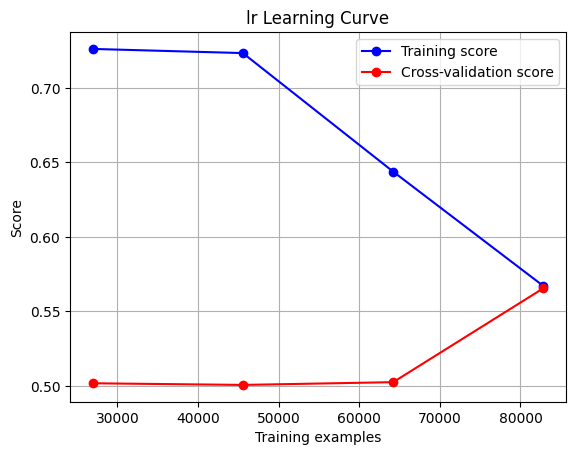

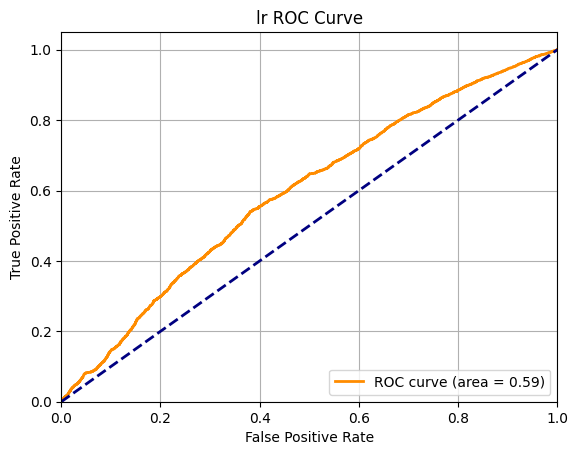

Fitting 5 folds for each of 81 candidates, totalling 405 fits


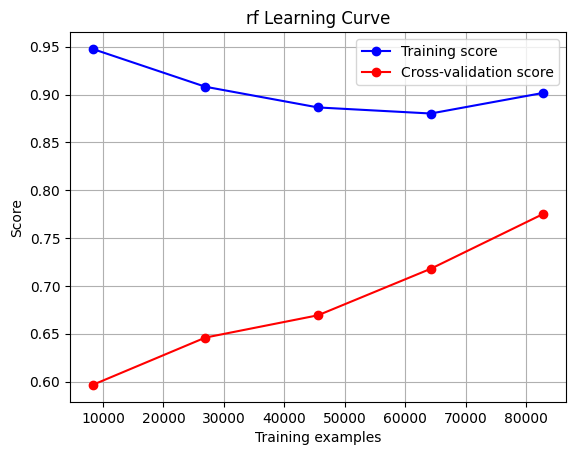

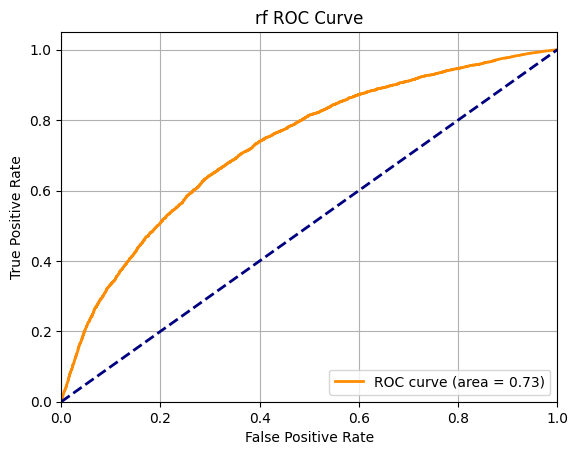

Fitting 5 folds for each of 9 candidates, totalling 45 fits


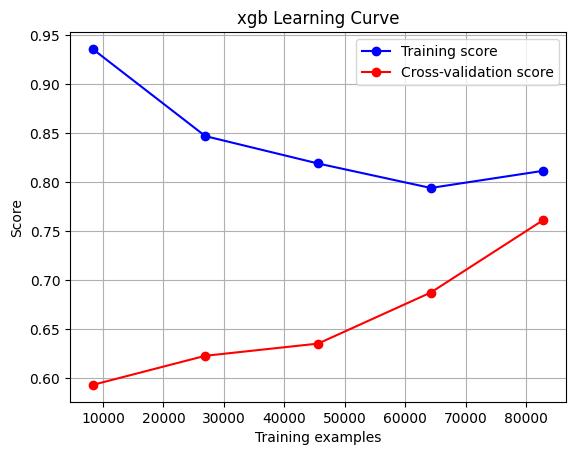

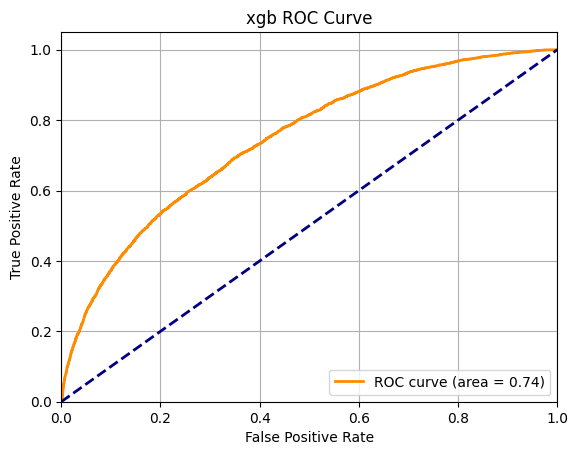

Fitting 5 folds for each of 9 candidates, totalling 45 fits


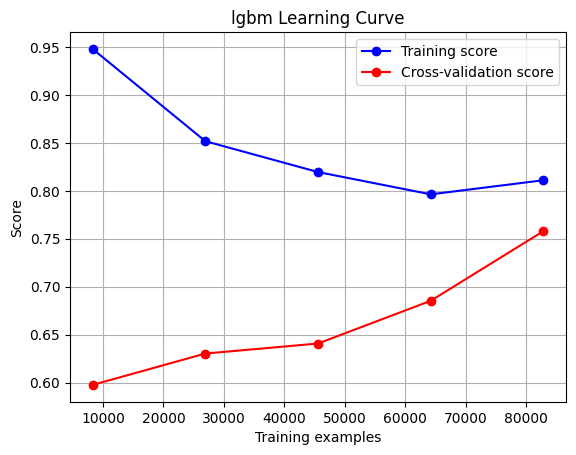

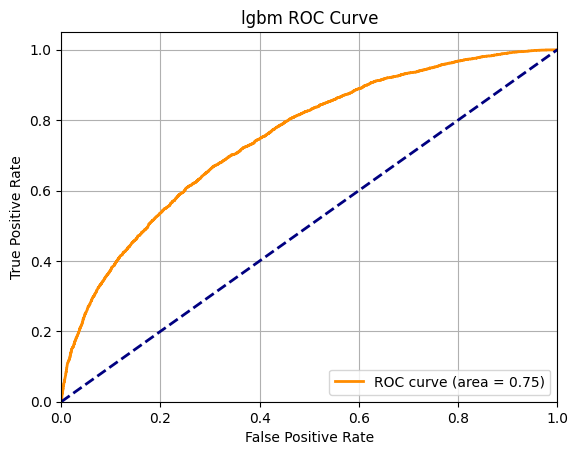

Fitting 5 folds for each of 108 candidates, totalling 540 fits


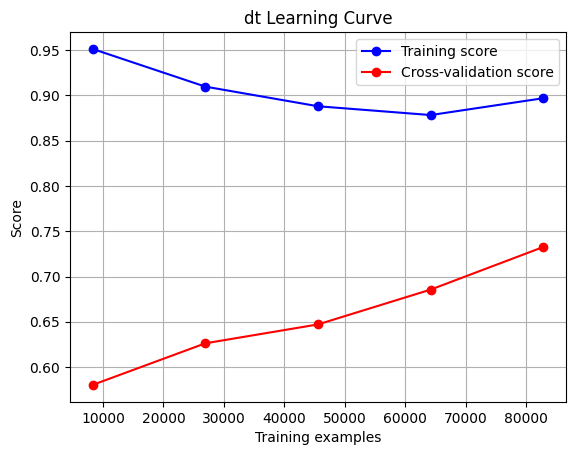

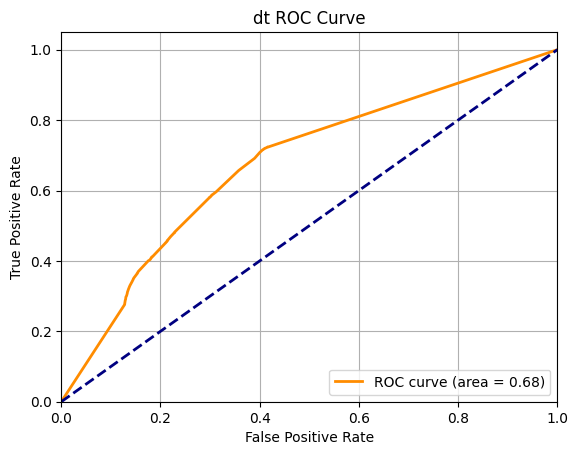

Fitting 5 folds for each of 27 candidates, totalling 135 fits


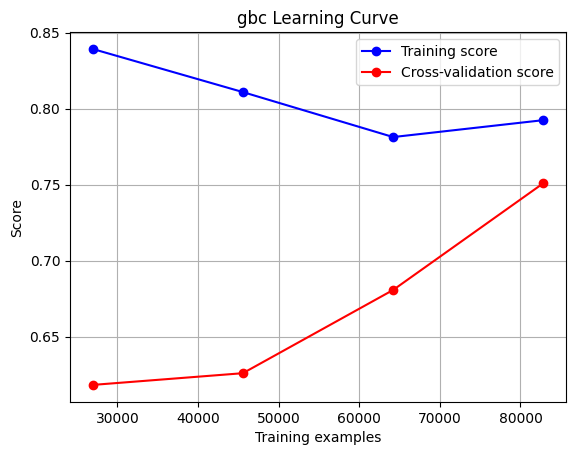

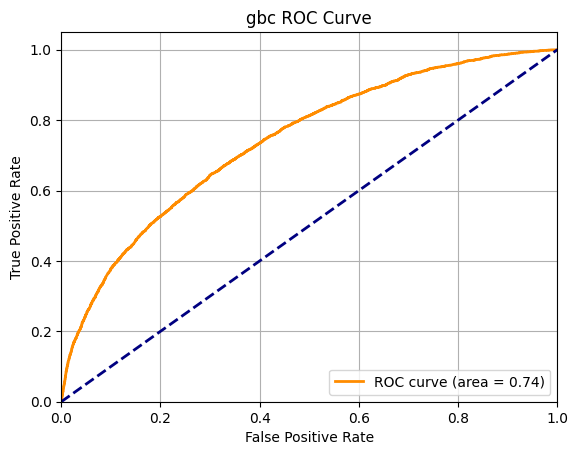

Fitting 5 folds for each of 2 candidates, totalling 10 fits


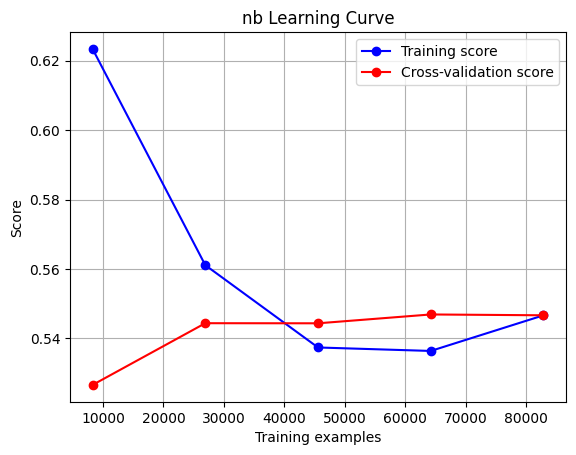

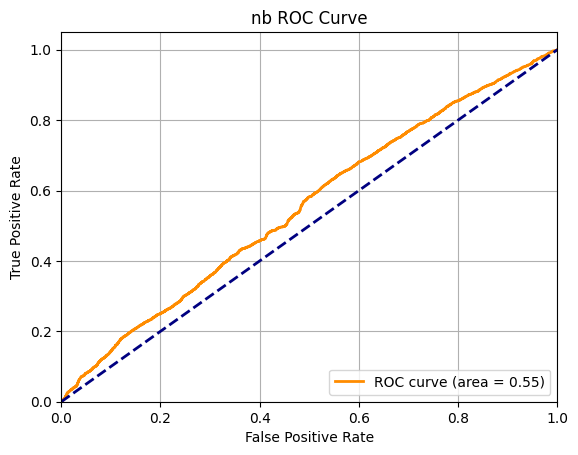

c:\Users\Allan\Documents\MGI\predict-ia-notebook\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


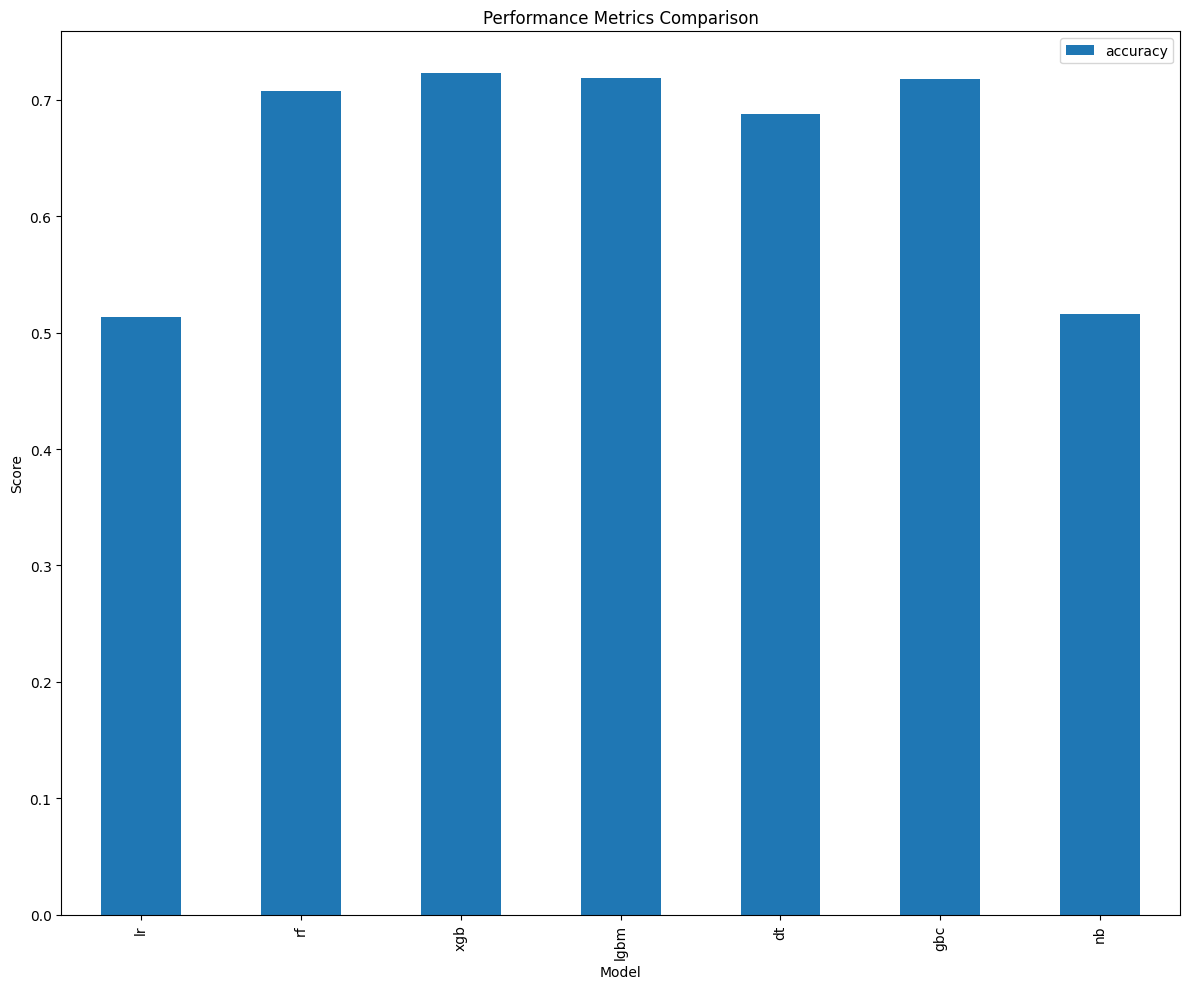

In [26]:
# Commencer le run parent MLflow pour l'expérience globale
with mlflow.start_run(run_name='Model_Comparison_Criticality') as parent_run:
    # Variables pour suivre le meilleur modèle
    best_score = -1
    best_model_name = None
    best_model = None
    results = []


    # Définition des fonctions de score personnalisées pour une utilisation future dans la sélection et l'évaluation des modèles

    # Fonction pour calculer la précision pour la classe "True" spécifiquement.
    # Cette fonction sera utilisée pour créer un scoreur personnalisé adapté à nos besoins d'évaluation spécifiques.
    def precision_score_class_true(y_true, y_pred):
        return precision_score(y_true, y_pred, pos_label=True)  

    # Création d'un scoreur personnalisé à partir de la fonction de précision ci-dessus.
    # Ce scoreur sera utilisé dans GridSearchCV pour optimiser les modèles en fonction de leur précision sur la classe "True".
    # Les scoreurs personnalisés sont essentiels lorsque les métriques d'évaluation standard de scikit-learn
    # ne répondent pas directement à nos besoins spécifiques. Ils permettent d'utiliser n'importe quelle fonction d'évaluation
    # personnalisée dans le cadre de la validation croisée et de l'optimisation des hyperparamètres avec GridSearchCV,
    # offrant ainsi une flexibilité pour se concentrer sur les aspects les plus pertinents de la performance du modèle.
    precision_true_scorer = make_scorer(precision_score_class_true)


    # Fonction pour calculer le F1 score pour la classe "True" spécifiquement.
    # Comme pour la précision, cette fonction sert à évaluer spécifiquement la performance du modèle sur la classe "True".
    def f1_score_class_true(y_true, y_pred):
        return f1_score(y_true, y_pred, pos_label=True)

    # Création d'un scoreur personnalisé pour le F1 score.
    # Utiliser un scoreur personnalisé avec GridSearchCV permet d'aligner étroitement le processus de sélection du modèle
    # avec les objectifs métier ou de recherche, en optimisant les modèles en fonction de métriques qui reflètent le mieux
    # les performances souhaitées dans le contexte d'application réel.
    f1_true_scorer = make_scorer(f1_score_class_true)

    # Boucle sur les modèles pour démarrer des runs enfants
    for model_name, pipeline in pipelines.items():
        # Commencer un run enfant pour chaque modèle
        with mlflow.start_run(run_name=f"{model_name}_model", nested=True):
            
            # Création d'une instance de GridSearchCV avec le pipeline et les paramètres correspondants
            model = GridSearchCV(pipeline, param_grids[model_name], cv=5, verbose=2, n_jobs=-1, scoring="accuracy", refit=True, return_train_score=True)
            # Entraînement du modèle GridSearchCV sur l'ensemble d'entraînement
            model.fit(X_train, y_train)
            
            # Prédiction sur l'ensemble de test
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]  # Predict probabilities for the positive class
            
            # Calcul de l'accuracy et du recall sur l'ensemble de test
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro')  # "macro" pour la precision non pondérée
            recall = recall_score(y_test, y_pred, average='macro')  # "macro" pour le recall non pondéré
            roc_auc = roc_auc_score(y_test, y_pred_proba)  # Calculate AUC-ROC

            # Après avoir sélectionné le meilleur modèle via GridSearchCV, nous calculons des métriques clés
            # pour évaluer sa performance sur l'ensemble de test. Ces métriques incluent la précision et le F1 score pour la classe "True",
            # qui nous fournissent des informations précieuses sur la capacité du modèle à identifier correctement la classe d'intérêt.

            # Calcul de la précision pour la classe "True" spécifiquement.
            # Cette métrique est particulièrement utile pour évaluer la performance du modèle dans la prédiction des cas positifs (erreur).
            precision_class_true = precision_score(y_test, y_pred, pos_label=True)  # Utilisé pour l'évaluation post-entraînement

            # Calcul du F1 score pour la classe "True" spécifiquement.
            # Le F1 score combine la précision et le rappel, offrant une vue d'ensemble de la performance du modèle sur la classe "True".
            f1_class_true = f1_score(y_test, y_pred, pos_label=True)  # Utilisé pour l'évaluation post-entraînement

            # Stockage des résultats dans une liste pour le traçage ultérieur
            results.append({"model": model_name, "accuracy": accuracy, "precision": precision, "recall": recall, "roc_auc": roc_auc,"precision_class_true": precision_class_true,"f1_class_true": f1_class_true})

            # Enregistrement des métriques avec mlflow
            mlflow.log_metric(f"{model_name}_accuracy", accuracy)
            mlflow.log_metric(f"{model_name}_recall", recall)
            mlflow.log_metric(f"{model_name}_roc_auc", roc_auc)
            mlflow.log_metric(f"{model_name}_precision", precision)
            # Enregistrement de la précision de la classe "True" avec MLflow
            mlflow.log_metric(f"{model_name}_precision_class_true", precision_class_true)
            # Enregistrement du F1 score de la classe "True" avec MLflow
            mlflow.log_metric(f"{model_name}_f1_score_class_true", f1_class_true)



            # Génération de la courbe d'apprentissage
            train_sizes, train_scores, test_scores = learning_curve(
                model.best_estimator_, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1,
                train_sizes=np.linspace(.1, 1.0, 5))
            plt.figure()
            plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label="Training score")
            plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='red', label="Cross-validation score")
            plt.title(f"{model_name} Learning Curve")
            plt.xlabel("Training examples")
            plt.ylabel("Score")
            plt.legend(loc="best")
            plt.grid(True)
            learning_curve_path = f"./mlflow_object/{model_name}_learning_curve.png"
            plt.savefig(learning_curve_path)
            plt.show()
            plt.close()

            
            
            # Enregistrement de la figure de la courbe d'apprentissage avec mlflow
            mlflow.log_artifact(learning_curve_path)
            
            # Génération de la courbe ROC
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{model_name} ROC Curve')
            plt.legend(loc="lower right")
            plt.grid(True)
            roc_curve_path = f"./mlflow_object/{model_name}_roc_curve.png"
            plt.savefig(roc_curve_path)
            plt.show()
            plt.close()
            
            # Enregistrement de la figure de la courbe ROC avec mlflow
            mlflow.log_artifact(roc_curve_path)

            # Mise à jour du meilleur modèle si nécessaire
            if accuracy > best_score:  
                best_score = accuracy
                best_model_name = model_name
                best_model = model            

            # Les runs enfants sont automatiquement terminés ici à la fin du bloc 'with'
                
    # Enregistrement de la métrique du meilleur modèle dans le run parent
    mlflow.log_metric("best_accuracy", best_score)
    if best_model_name:
        mlflow.set_tag("best_model_name", best_model_name)
        mlflow.sklearn.log_model(best_model.best_estimator_, f"best_model_{best_model_name}")

    # Conversion des résultats en DataFrame pour faciliter le traçage
    results_df = pd.DataFrame(results)

    # Prédiction avec le meilleur modèle sur l'ensemble de test
    y_pred_best = best_model.predict(X_test)

    # Calcul du recall général pour le meilleur modèle
    recall_general_best = recall_score(y_test, y_pred_best, average='macro')

    # Génération de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred_best)

    # Classes are simply True and False or 0 and 1
    classes = np.unique(y_test)

    # Création du DataFrame
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    # Enregistrement du DataFrame en format CSV
    confusion_matrix_path = "./mlflow_object/confusion_matrix.csv"
    cm_df.to_csv(confusion_matrix_path)
    mlflow.log_artifact(confusion_matrix_path)  # Enregistrement de l'artefact dans MLflow

    # Génération du rapport de classification
    report = classification_report(y_test, y_pred_best, target_names=classes.astype(str))

    classification_report_path = "./mlflow_object/classification_report.txt"
    with open(classification_report_path, "w") as f:
        f.write(report)
    mlflow.log_artifact(classification_report_path) 

    # Sauvegarde du scaler
    scaler_path = './mlflow_object/scaler.joblib'
    dump(scaler, scaler_path)
    mlflow.log_artifact(scaler_path)

    # Enregistrement des exemples d'entrée dans un fichier JSON
    input_example_path = "./mlflow_object/input_exemple.json"
    with open(input_example_path, "w") as f:
        json.dump(example_input_json, f)
    mlflow.log_artifact(input_example_path)

    # Convertir et enregistrer le schéma de sortie dans un fichier JSON
    output_schema_path = "./mlflow_object/output_schema.json"
    with open(output_schema_path, "w") as f:
        json.dump(output_schema, f)
    mlflow.log_artifact(output_schema_path)

    # Enregistrement des hyperparamètres de chaque modèle au format JSON
    hyperparams_path = "./mlflow_object/model_hyperparams_values.json"
    with open(hyperparams_path, "w") as f:
        json.dump(model_hyperparams_values, f)
    mlflow.log_artifact(hyperparams_path)

    # Sauvegarder l'indicateur d'augmentation des données
    mlflow.log_param("data_augmentation", data_augmentation_done)

    # Calcul de la moyenne des trois métriques pour chaque modèle
    # results_df['average'] = results_df[['accuracy', 'recall', 'roc_auc']].mean(axis=1)

    # Tracé des résultats
    fig, ax = plt.subplots(figsize=(12, 10))
    # results_df.plot(kind='bar', x='model', y=['accuracy', 'recall', 'roc_auc', 'average'], ax=ax)
    results_df.plot(kind='bar', x='model', y='accuracy', ax=ax)
    ax.set_title('Performance Metrics Comparison')
    ax.set_ylabel('Score')
    ax.set_xlabel('Model')
    plt.tight_layout()
    evaluation_metrics_plot_path = "./mlflow_object/evaluation_metrics_plot.png"
    plt.savefig(evaluation_metrics_plot_path)
    plt.show()
    mlflow.log_artifact(evaluation_metrics_plot_path)

    # Enregistrement des informations du meilleur modèle
    best_model_info_path = "./mlflow_object/best_model_info.json"
    # Affichage du meilleur modèle
    best_model_info = {
        "description": f"Le meilleur modèle de prediction de criticité du run est {best_model_name} avec la metric choisi qui est l'accuracy qui est de {best_score:.3f} pour ce run",
        "params": best_model.best_estimator_.get_params(),
        "params_type": f"{models} (indique la catégorie de paramètres utilisée : 'heavy', 'medium', 'light', ou 'test'. 'Heavy' implique un grand nombre de paramètres, 'medium' un nombre modéré, 'light' un nombre restreint, tandis que 'test' désigne des modèles et hyperparamètres simplifiés pour des tests rapides du pipeline)",
        "scaler used" : scaler_used,
        "sampling_info": sampling_info,
        "test_size_pourcentage" : round(test_size_percentage, 2),
        "X_train_sampling" : str(X_train.shape[0]),
        "y_train_sampling" : str(y_train.shape[0]),
        "X_test_sampling" : str(X_test.shape[0]),
        "y_test_sampling" : str(y_test.shape[0]),
        "gridsearch_details": {
        "cv": 5,
        "scoring_metric": "recall"
    },"learningcurve_details": {
        "cv": 5,
        "scoring_metric": "recall"
    },
    "params_choice" : params_choice,
    "miscellaneous note" : ""
    }

    # Conversion de tout objet non sérialisable en chaîne de caractères
    best_model_info["params"] = {k: str(v) for k, v in best_model_info["params"].items()}

    # Enregistrement des informations du meilleur modèle dans un fichier JSON
    best_model_info_path = "./mlflow_object/best_model_info.json"
    with open(best_model_info_path, "w") as f:
        json.dump(best_model_info, f)
    mlflow.log_artifact(best_model_info_path)
        # Convertion du DataFrame en un dictionnaire pour préparer l'enregistrement JSON
    results_dict = results_df.to_dict(orient='records')

    # Restructuration de dictionnaire pour le formatage souhaité
    restructured_dict = {
        model['model']: {
            'accuracy': model['accuracy'],
            'recall': model['recall'],
            'roc_auc': model['roc_auc']
            # 'average': model['average']
        } for model in results_dict
    }

    # Enregistrement des résultats de test des modèles dans un fichier JSON
    results_test_model_path = './mlflow_object/result_test_model.json'
    with open(results_test_model_path, 'w') as f:
        json.dump(restructured_dict, f)
    mlflow.log_artifact(results_test_model_path)

    mlflow.set_tag("params_choice", params_choice)
    mlflow.set_tag("balanced_method", balanced_method)

    
        
    # Le run parent est automatiquement terminé ici à la fin du bloc 'with'

mlflow.end_run()